In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.optimize import linear_sum_assignment

%matplotlib inline
sns.set()

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

# Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [2]:
df_lalonde = pd.read_csv('lalonde.csv')

In [3]:
df_lalonde.head(5)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [4]:
df_lalonde[['treat', 're78']].groupby('treat').describe()

re78                                                                \
       count         mean          std  min       25%       50%        75%   
treat                                                                        
0      429.0  6984.169742  7294.161791  0.0  220.1813  4975.505  11688.820   
1      185.0  6349.143530  7867.402218  0.0  485.2298  4232.309   9642.999   

                 
            max  
treat            
0      25564.67  
1      60307.93

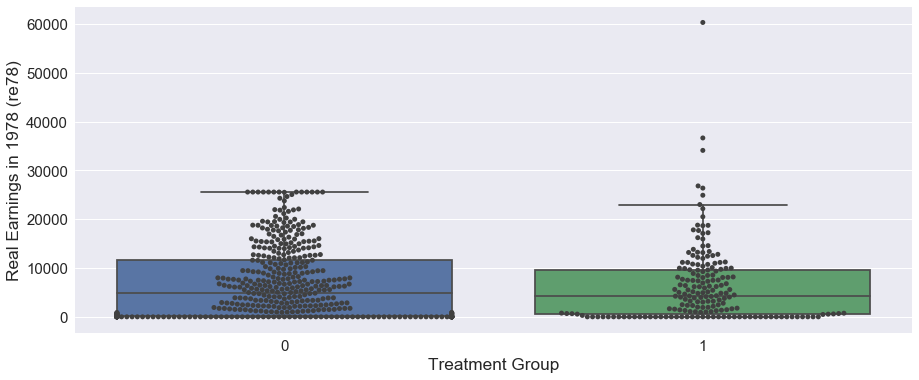

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x = 'treat', y = 're78', data = df_lalonde, showfliers=False);
sns.swarmplot(x = 'treat', y = 're78', data = df_lalonde, color=".25");
plt.xlabel('Treatment Group', fontsize='x-large');
plt.ylabel('Real Earnings in 1978 (re78)', fontsize='x-large');

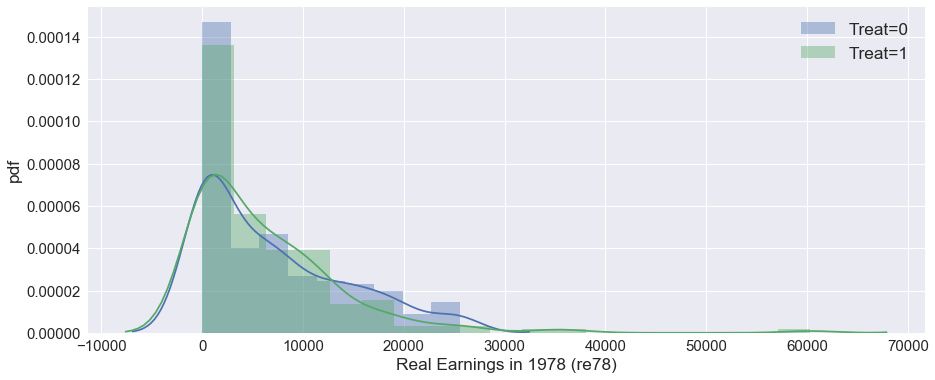

In [6]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(df_lalonde.loc[df_lalonde['treat'] == 0]['re78'])
sns.distplot(df_lalonde.loc[df_lalonde['treat'] == 1]['re78'])
ax.legend(['Treat=0', 'Treat=1'], loc='best', fontsize='x-large');
plt.ylabel('pdf', fontsize='x-large');
plt.xlabel('Real Earnings in 1978 (re78)', fontsize='x-large');

**Observations :**

The naive "researcher" would conclude that "treatment" represented by the job training program did not affect the outcome and was not effective because `re78` for the treatment group (Treat = 1) has lower (but close) values for the mean and almost all the quartiles (although, in the treat group there are some outliers).

The problem with this naive analysis is that the experiment is not sufficiently randomized (even the number of participants is small). This is problematic because for eg. people with lower incomes are more susceptible to join the training program. Even if the training program was successful and the incomes increased for most of them, the statistics of earnings could still be lower than that of the control (not-treat) group, which will be indicative of a failed experiment to the naive researcher. 

Ideally, distribution of all the features should be similar in both the groups in order to make the outcome variables "comparable" and thus of any value.

### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

In [7]:
#Melting the df to change it to long format, makes plotting multiple variables easier
df_temp = pd.melt(df_lalonde, id_vars = ['treat'], value_vars = ['re74', 're75', 're78'])

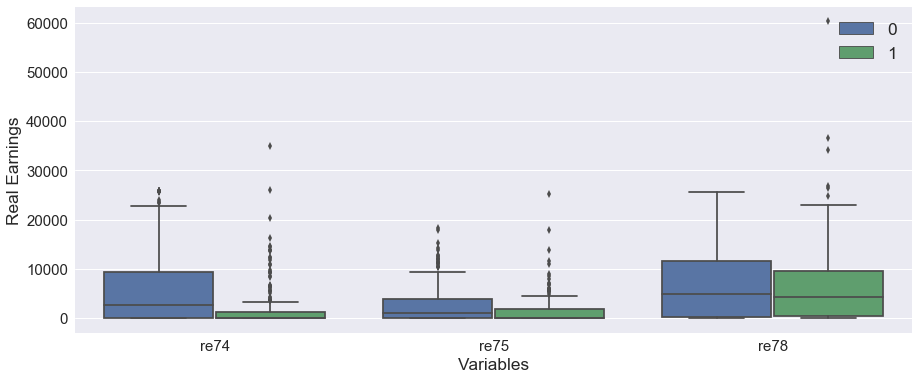

In [8]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x = 'variable', y = 'value', hue = 'treat', data = df_temp);
ax.legend(loc='best', fontsize='x-large');
plt.ylabel('Real Earnings', fontsize='x-large');
plt.xlabel('Variables', fontsize='x-large');

In [9]:
#defining temporary df for plotting
df_temp = pd.melt(df_lalonde, id_vars = ['treat'], value_vars = ['age', 'educ'])

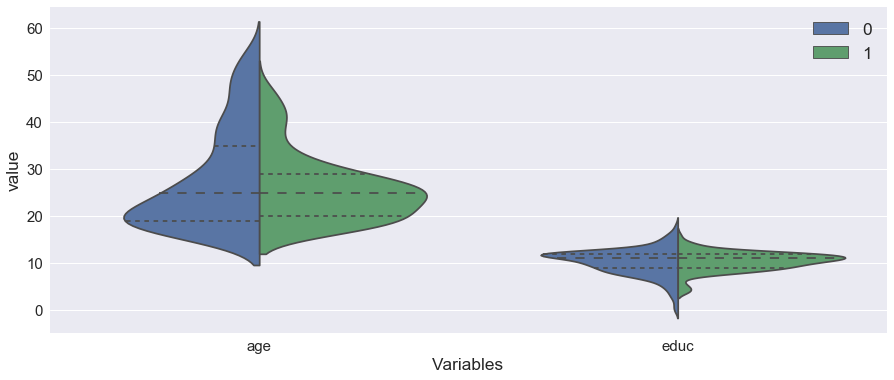

In [10]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.violinplot(x = 'variable', y = 'value', hue = 'treat', data = df_temp, split=True, inner="quartile");
ax.legend(loc='best', fontsize='x-large');
plt.xlabel('Variables', fontsize='x-large');
plt.ylabel('value', fontsize='x-large');

In [11]:
#defining temporary df for plotting
df_temp = pd.melt(df_lalonde, id_vars = ['treat'], value_vars = ['black', 'hispan', 'married', 'nodegree'])

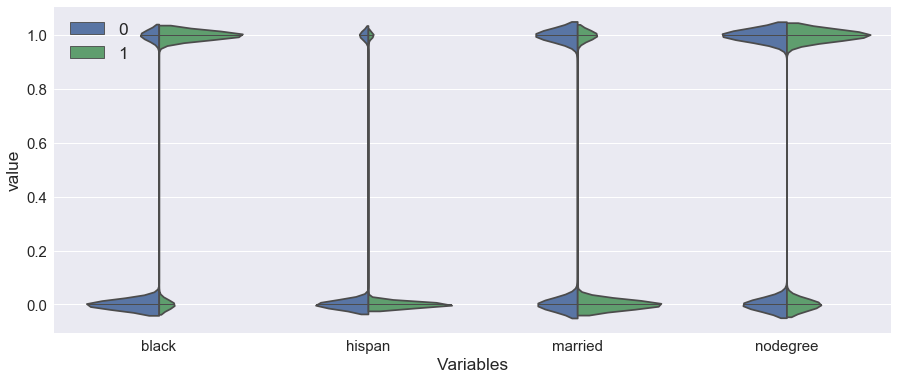

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.violinplot(x = 'variable', y = 'value', hue = 'treat', data = df_temp, split=True, inner='stick', bw=0.05);
ax.legend(loc='best', fontsize='x-large');
plt.xlabel('Variables', fontsize='x-large');
plt.ylabel('value', fontsize='x-large');

**Interpretation :**

The violoin plot is an intersting way to visualize distributions. It shows the distribution of quantitative data across several levels of one (or more) categorical variables such that those distributions can be compared. For each variable, on each side of the vertical line is a rotated kernel density plot of the variable under the two categories.

Note that, although `black`, `hispan`, `married` and `nodegree` are binary variables, we still chose to use the violin plot, in order to be consistent and also because it still gives a good idea about their distribution (by making the `bw` parameter close to zero, it almost looks like a histogram)

**Observations :**

* Just looking at the trend of `re78` in the treat group, it appears that there were significant imporovements in the earnings. But alone it is not indicative of the effectiveness of the training program at all because such improvement could be global (will also be present in the cotrol group, which it is).

* The distribution of underlying binary variables `black`, `hispan`, and `married` in the two groups are quite dissimilar, while for variables `nodegree`, `age` and `edu` it it less so.

* There proportion of blacks and unmarried is higher in the treat group suggesting a bias in the assignment (or voluntary choice) to treat, perhaps beacuse they earn less on average and thus feel strongly for an improvement program.

**Implications on Naive Analysis: **

* Since the distribution for variables/features for the population in the two different groups are dissimilar, the naive conclusion from the observational study would be incorrect. The population in the two groups are quite different and thus factors like - difference in rate of increment in earnings with respect to age and education, discrimiation in pay based on ethnicity, etc. will affect the two populations differently.

### 3. A propsensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

In [13]:
logistic = linear_model.LogisticRegression()

In [14]:
#Data for training the logistic regression
#we keep only pre-treatment variables
x = df_lalonde[['age','educ','black','hispan','married','nodegree','re74','re75']]
y = df_lalonde['treat']

In [15]:
logistic.fit(x,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
logistic.score(x,y)
#scores closer to 1 would mean good fit
#moreover, overfitting may be benficial for matching in observatinal studies

0.80781758957654726

In [17]:
propensity = logistic.predict_proba(x)
#calculating probabilities as P(Z=0|x) and P(Z=1|x)

In [18]:
df_lalonde['propensity'] = propensity[:,1]
#propensity equals the probability of a participant to be in 'treat', so we pick the second column

In [19]:
df_lalonde.head(5)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


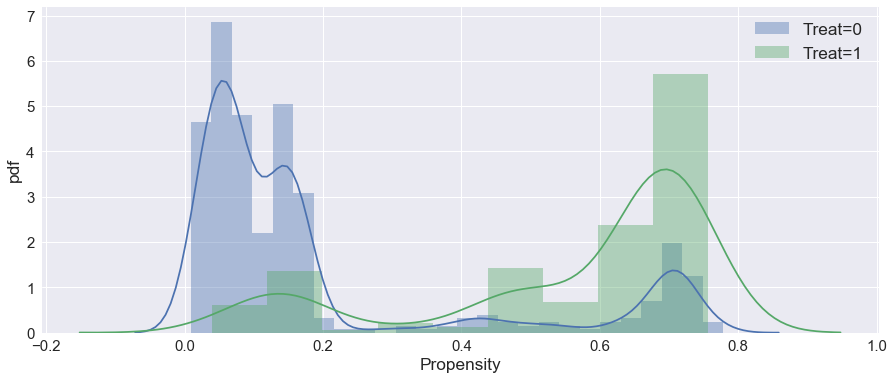

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(df_lalonde.loc[df_lalonde['treat'] == 0]['propensity'])
sns.distplot(df_lalonde.loc[df_lalonde['treat'] == 1]['propensity'])
ax.legend(['Treat=0', 'Treat=1'], loc='best', fontsize='x-large');
plt.ylabel('pdf', fontsize='x-large');
plt.xlabel('Propensity', fontsize='x-large');

We can see that the two populations are unbalanced and the propensity score seeks a redistribution/elimation of/from the population.

### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [21]:
df_treat = df_lalonde[df_lalonde['treat']==1]

In [22]:
df_control = df_lalonde[df_lalonde['treat']==0]

In [23]:
#Hungarian Algorithm for matching
#Define a N times M cost matrix where N = #treat and M=#control
#cost[i,j] is the absolute difference of propensity score for ith and jth individual respectively in treat and control

num_treat = df_lalonde[df_lalonde['treat']==1].shape[0]
num_control = df_lalonde[df_lalonde['treat']==0].shape[0]

cost = np.zeros((num_treat, num_control))

for i in range(num_treat):
    for j in range(num_control):
        cost[i][j] = abs(df_treat.iloc[i]['propensity'] - df_control.iloc[j]['propensity'])

### Hungarian Algorithm

Let $\mathbf{C}$ and $\mathbf{P}$ be the cost and assignment matrices, respectively.

$\mathbf{C}_{i,j}$ represents the cost of matching $i^\text{th}$ treat individual with $j^\text{th}$ control individual.

$$
\begin{aligned}
\mathbf{C}_{i,j} = \text{Propensity}(i_{\text{treat}}) - \text{Propensity}(j_{\text{control}})
\end{aligned}
$$


$$
\begin{aligned}
\begin{equation}
  \mathbf{P}_{i,j} =\left\{
  \begin{array}{@{}ll@{}}
    1, & \text{if $i^\text{th}$ treat individual with $j^\text{th}$ control individual}\ a=1 \\
    0, & \text{otherwise}
  \end{array}\right.
\end{equation} 
\end{aligned}
$$

Thus we can now formalize the optimization as follows :


$$
\begin{aligned}
\begin{equation}
  \begin{array}{@{}ll@{}}
    &\underset{\mathbf{P}}{\operatorname{argmin}} &\sum_i\sum_j \mathbf{P}_{i,j}\mathbf{C}_{i,j} \\
    &\text{s.t.} &\sum_{i=0}^{\#treat} \mathbf{P}_{i,j}  \in \{0, 1\}  \\
    & &\sum_{j=0}^{\#control} \mathbf{P}_{i,j}  = 1 \\
    & &\mathbf{P}_{i,j} \in \{0, 1\}  \\
  \end{array}
\end{equation} 
\end{aligned}
$$

Thus, each data point from the treated group is matched exactly with one data point from the control group and weach data point from the control group is matched with at most one data point from the treated group, as desired.

We will use the `scipy` implementation for the Hungarian algorithm. Note that its is very similar to bi-partite matching on graphs.

In [24]:
cost[0:5,0:5]

array([[ 0.39284643,  0.41002   ,  0.42077602,  0.41844395,  0.02729603],
       [ 0.09415554,  0.11132911,  0.12208513,  0.11975306,  0.27139486],
       [ 0.67185064,  0.68902421,  0.69978023,  0.69744816,  0.30630024],
       [ 0.61364653,  0.63082009,  0.64157611,  0.63924405,  0.24809612],
       [ 0.64778162,  0.66495519,  0.67571121,  0.67337914,  0.28223122]])

In [25]:
#linear_sum_assignment implements the Hungarian alogrithm
#row_ind is ordered and the corresponding element in col_ind represents the match from the control group
row_ind, col_ind = linear_sum_assignment(cost)

In [26]:
col_ind[0:10]

array([264, 394, 210, 401, 427, 411, 415, 205, 413,  39])

In [27]:
#reindexing df_control in the order of their matching with the treat group
df_control_matched = df_control.iloc[col_ind]
df_control_matched.index = pd.Series(df_treat.index)

In [28]:
df_matched = pd.concat([df_treat, df_control_matched])
df_matched_flat = pd.merge(df_treat, df_control_matched, left_index=True, right_index=True, suffixes=('_treat', '_control'))

In [29]:
df_matched.shape

(370, 12)

In [30]:
df_matched[['treat', 're78']].groupby('treat').describe()

re78                                                               \
       count         mean          std  min       25%       50%       75%   
treat                                                                       
0      185.0  5312.474907  5842.884861  0.0    0.0000  3392.860  7933.914   
1      185.0  6349.143530  7867.402218  0.0  485.2298  4232.309  9642.999   

                 
            max  
treat            
0      20243.38  
1      60307.93

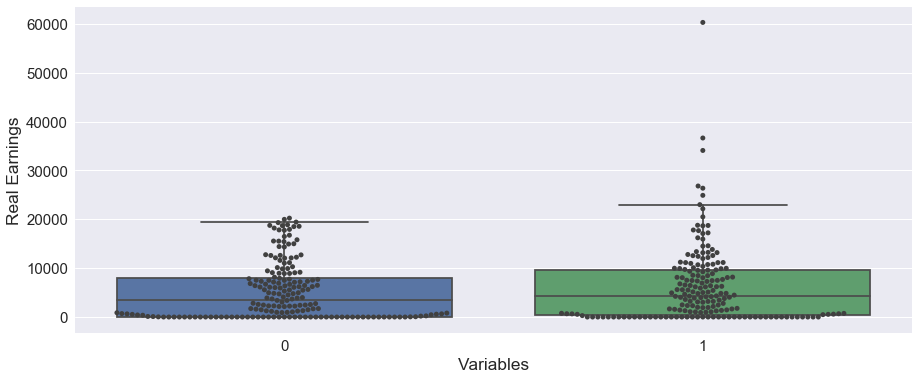

In [31]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='treat', y = 're78', data = df_matched, showfliers=False);
sns.swarmplot(x = 'treat', y = 're78', data = df_matched, color=".25");
plt.ylabel('Real Earnings', fontsize='x-large');
plt.xlabel('Variables', fontsize='x-large');

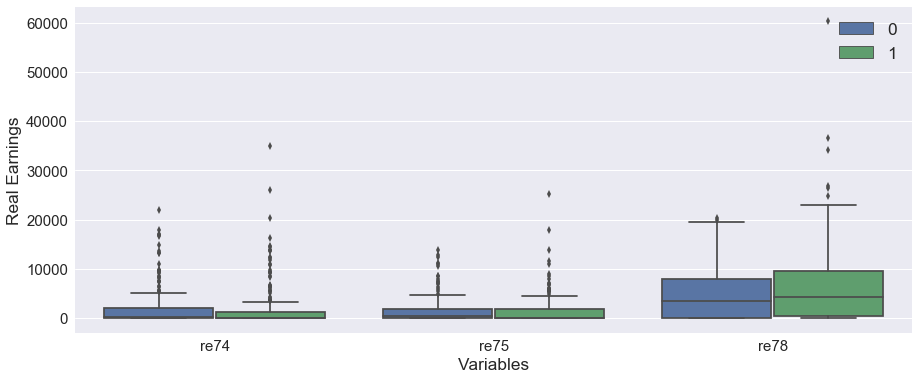

In [32]:
df_new = pd.melt(df_matched, id_vars = ['treat'], value_vars = ['re74', 're75', 're78'])
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x = 'variable', y = 'value', hue = 'treat', data = df_new);
ax.legend(loc='best', fontsize='x-large');
plt.xlabel('Variables', fontsize='x-large');
plt.ylabel('Real Earnings', fontsize='x-large');

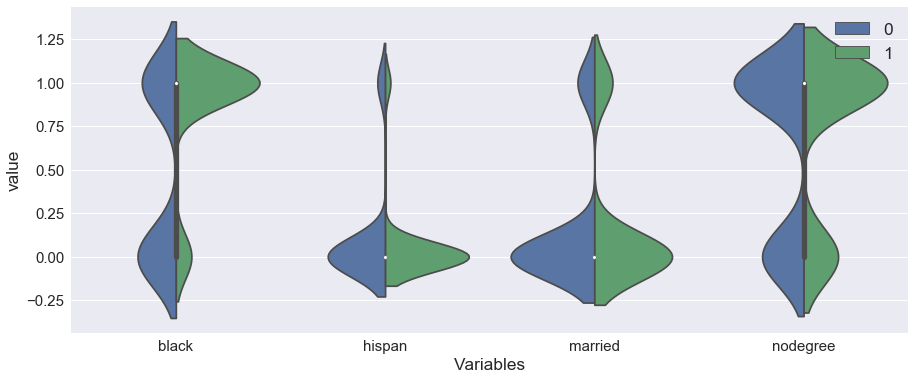

In [33]:
df_new = pd.melt(df_matched, id_vars = ['treat'], value_vars = ['black', 'hispan', 'married', 'nodegree'])
fig, ax = plt.subplots(figsize=(15, 6))
sns.violinplot(x = 'variable', y = 'value', hue = 'treat', data = df_new, split=True);
ax.legend(loc='best', fontsize='x-large');
plt.xlabel('Variables', fontsize='x-large');
plt.ylabel('value', fontsize='x-large');

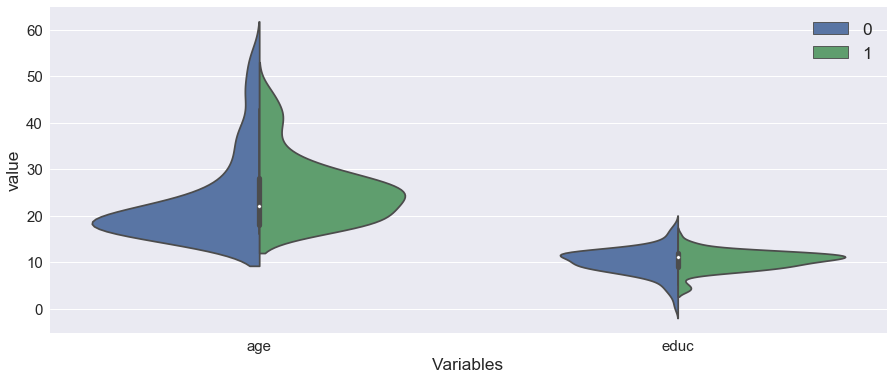

In [34]:
df_new = pd.melt(df_matched, id_vars = ['treat'], value_vars = ['age', 'educ'])
fig, ax = plt.subplots(figsize=(15, 6))
sns.violinplot(x = 'variable', y = 'value', hue = 'treat', data = df_new, split=True);
ax.legend(loc='best', fontsize='x-large');
plt.xlabel('Variables', fontsize='x-large');
plt.ylabel('value', fontsize='x-large');

** Observations :**

The distribution of `married`, `nodegree`, `hispan`, `age` and `educ` are more similar now, while for `black` it is still quite dissimilar. Nonetheless, we are in a much better position to comment about the effectiveness as now the effects which are independant of the training program caused by these features will be similar on the two groups and thus any difference in the outcome would be indicative of the effectiveness of the training program.

The mean and all the quartile values for `re78` response is higher for the **treat** group now, which indicates that the training program was indeed a **positive** impact on the earnings. 

### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

**Answer :**

The dataset is still not sufficiently balanced because there is disparity in terms of race : in the treat group there is a larger proportion of blacks.

If the population in the two groups are quite different in terms of race, factors like discrimiation in pay based on ethnicity, etc will affect the two populations differently. This essentially means that external factors depandant on race which could affect the earnings, will be unaccounted for in our observational study. Dur to lack of this information, we may then wrongly associate any such change (improvements or otherwise) with the training programme. 

More strictally, ideally the joint distribution of all the variables in the two groups should be similar. But with the assumption of independence, we can ignore that requirement and still get reasonable analysis.

Lets look closely at the distribution of `black`.

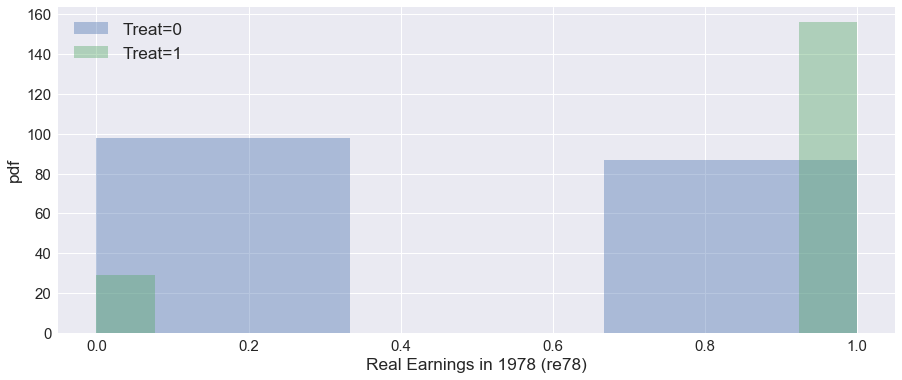

In [35]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(df_matched.loc[df_matched['treat'] == 0]['black'], kde=False)
sns.distplot(df_matched.loc[df_matched['treat'] == 1]['black'], kde=False)
ax.legend(['Treat=0', 'Treat=1'], loc='best', fontsize='x-large');
plt.ylabel('pdf', fontsize='x-large');
plt.xlabel('Real Earnings in 1978 (re78)', fontsize='x-large');

In [36]:
df_balanced = df_matched_flat[df_matched_flat['black_treat'] == df_matched_flat['black_control']]

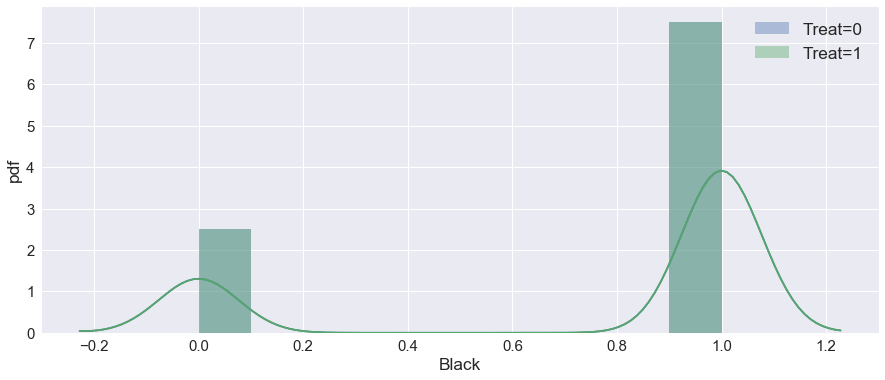

In [37]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(df_balanced['black_treat'], kde=True)
sns.distplot(df_balanced['black_control'], kde=True)
ax.legend(['Treat=0', 'Treat=1'], loc='best', fontsize='x-large');
plt.ylabel('pdf', fontsize='x-large');
plt.xlabel('Black', fontsize='x-large');

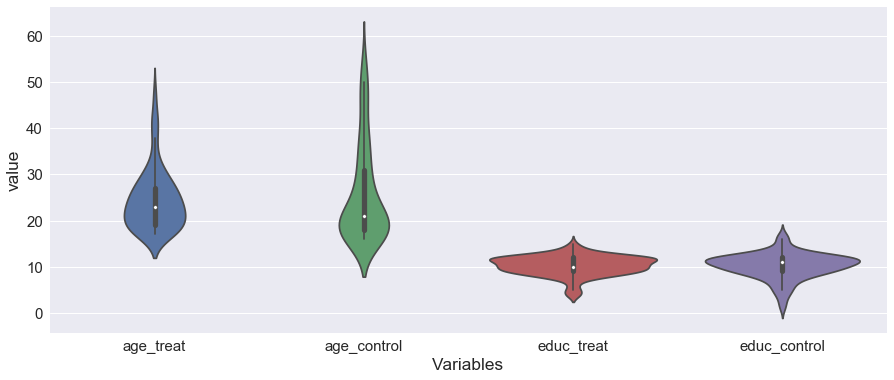

In [38]:
df_new = pd.melt(df_balanced, value_vars = ['age_treat', 'age_control', 'educ_treat', 'educ_control'])
fig, ax = plt.subplots(figsize=(15, 6))
sns.violinplot(x = 'variable', y = 'value', data = df_new, split=True);
plt.xlabel('Variables', fontsize='x-large');
plt.ylabel('value', fontsize='x-large');

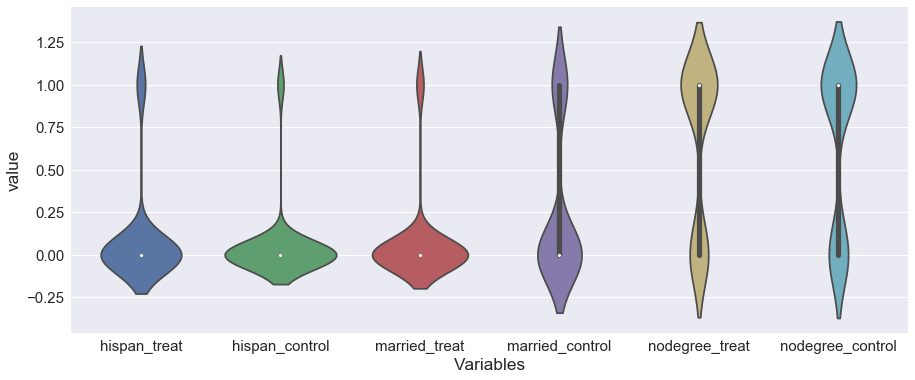

In [39]:
df_new = pd.melt(df_balanced, value_vars = ['hispan_treat', 'hispan_control', 'married_treat','married_control', 'nodegree_treat','nodegree_control'])
fig, ax = plt.subplots(figsize=(15, 6))
sns.violinplot(x = 'variable', y = 'value', data = df_new, split=True);
plt.xlabel('Variables', fontsize='x-large');
plt.ylabel('value', fontsize='x-large');

**We can now see that all the features are well balanced and have the same distribution for both the treat and control group.**

### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

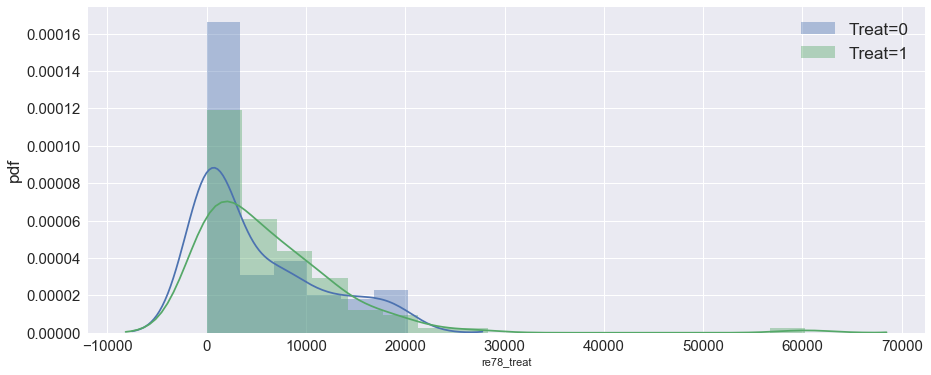

In [40]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(df_balanced['re78_control'], kde=True)
sns.distplot(df_balanced['re78_treat'], kde=True)
ax.legend(['Treat=0', 'Treat=1'], loc='best', fontsize='x-large');
plt.ylabel('pdf', fontsize='x-large');

In [41]:
df_balanced[['re78_treat', 're78_control']].describe()

,re78_treat,re78_control
count,116.000000,116.000000
mean,6359.890892,5052.665573
std,7708.774707,6130.298700
min,0.000000,0.000000
25%,665.300000,0.000000
50%,4648.736000,2195.163000
75%,9633.194250,8340.658000
max,60307.930000,20243.380000


In [42]:
print('Mean of earnings difference between pairs = {}'.
      format((df_balanced['re78_treat'] - df_balanced['re78_control']).mean()))
print('Scaled Mean of earnings difference between pairs = {}'.
      format((df_balanced['re78_treat'] - df_balanced['re78_control']).mean()/df_lalonde['re78'].mean()))
print('Number of pairs where the earning increasd = {}'.
      format((df_balanced['re78_treat'] - df_balanced['re78_control'] > 0).sum()))

Mean of earnings difference between pairs = 1307.2253193965514
Scaled Mean of earnings difference between pairs = 0.19244180359050747
Number of pairs where the earning increasd = 61


It is now clear that the distribution of `re78` for **treat group** is **positiviely skewed** with respect to the control group. Thus we conclude that the training program was **effective**.

Since we have a pairs/twins which are similar with respect to the underlying features corresponding to measurements **before** the training program, statistics on the pairwise difference for `re78` values would also be interesting.